In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
import matplotlib.patches as mpatches

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from models.evidential import Evidential
from models.baseline import Baseline
from models.dropout import Dropout
from models.ensemble import Ensemble

from datasets.nuscenes import *
from tools.metrics import *

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
nusc, dataroot = get_nusc("trainval", "../../data/nuscenes")
nusc_data = NuScenesDataset(nusc, False, "vehicle", ood=True, yaw=180)

['static_object.bicycle_rack', 'vehicle.bicycle'] ['vehicle.motorcycle']


In [8]:
len(nusc_data)

1344

In [15]:
ufce_vs_er = Evidential([7], backbone='cvt', n_classes=2)
ufce_vs_er.load(torch.load("../outputs_bin/nuscenes/aug/cvt_ufocal_gamma=.05_ol=.01_k=64/18.pt"))
# uce_ent_vs_er = Evidential([7], backbone='cvt', n_classes=2)
# uce_ent_vs_er.load(torch.load("../outputs_bin/nuscenes/aug/cvt_uce_ol=.01_k=64/19.pt"))
# ufce_er = Evidential([7], backbone='cvt', n_classes=2)
# ufce_er.load(torch.load("../outputs_bin/nuscenes/aug/cvt_ufocal_gamma=.05_ol=.01_k=0/19.pt"))
# ufce = Evidential([7], backbone='cvt', n_classes=2)
# ufce.load(torch.load("../outputs_bin/nuscenes/vehicle/cvt_ufocal_gamma=.05/19.pt"))
uce_ent_er = Evidential([7], backbone='cvt', n_classes=2)
uce_ent_er.load(torch.load("../outputs_bin/nuscenes/aug/cvt_uce_ol=.01_k=0/19.pt"))

Loaded pretrained weights for efficientnet-b4
BETA LAMBDA: 0.001
VAC SCALING FACTOR: 0
OOD WEIGHT: 0.01
Loaded pretrained weights for efficientnet-b4
BETA LAMBDA: 0.001
VAC SCALING FACTOR: 0
OOD WEIGHT: 0.01


In [11]:
energy = Baseline([7], backbone='cvt', n_classes=2)
energy.load(torch.load("../outputs_bin/nuscenes/aug/cvt_energy_gamma=.05_ol=.0001/19.pt"))

dropout = Dropout([7], backbone='cvt', n_classes=2)
dropout.load(torch.load("../outputs_bin/nuscenes/vehicle/cvt_baseline/19.pt"))

ensemble = Ensemble([7], backbone='cvt', n_classes=2)
ensemble.load([torch.load("../outputs_bin/nuscenes/vehicle/cvt_baseline/19.pt"), torch.load("../outputs_bin/nuscenes/vehicle/cvt_baseline_seed=1/19.pt"), torch.load("../outputs_bin/nuscenes/vehicle/cvt_baseline_seed=2/19.pt")])

Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Ensemble activation
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4
Loaded pretrained weights for efficientnet-b4


In [16]:
idxs = [0, 24, 70]
# models = [ufce_vs_er, uce_ent_vs_er, ufce_er, ufce, uce_ent]
models = [ufce_vs_er, uce_ent_er, energy, dropout, ensemble]
names = ["Ours", "ENN-UCE", "Energy", "Dropout", "Ensemble"]
nmodels = len(models)
samples = len(idxs)
size = 4

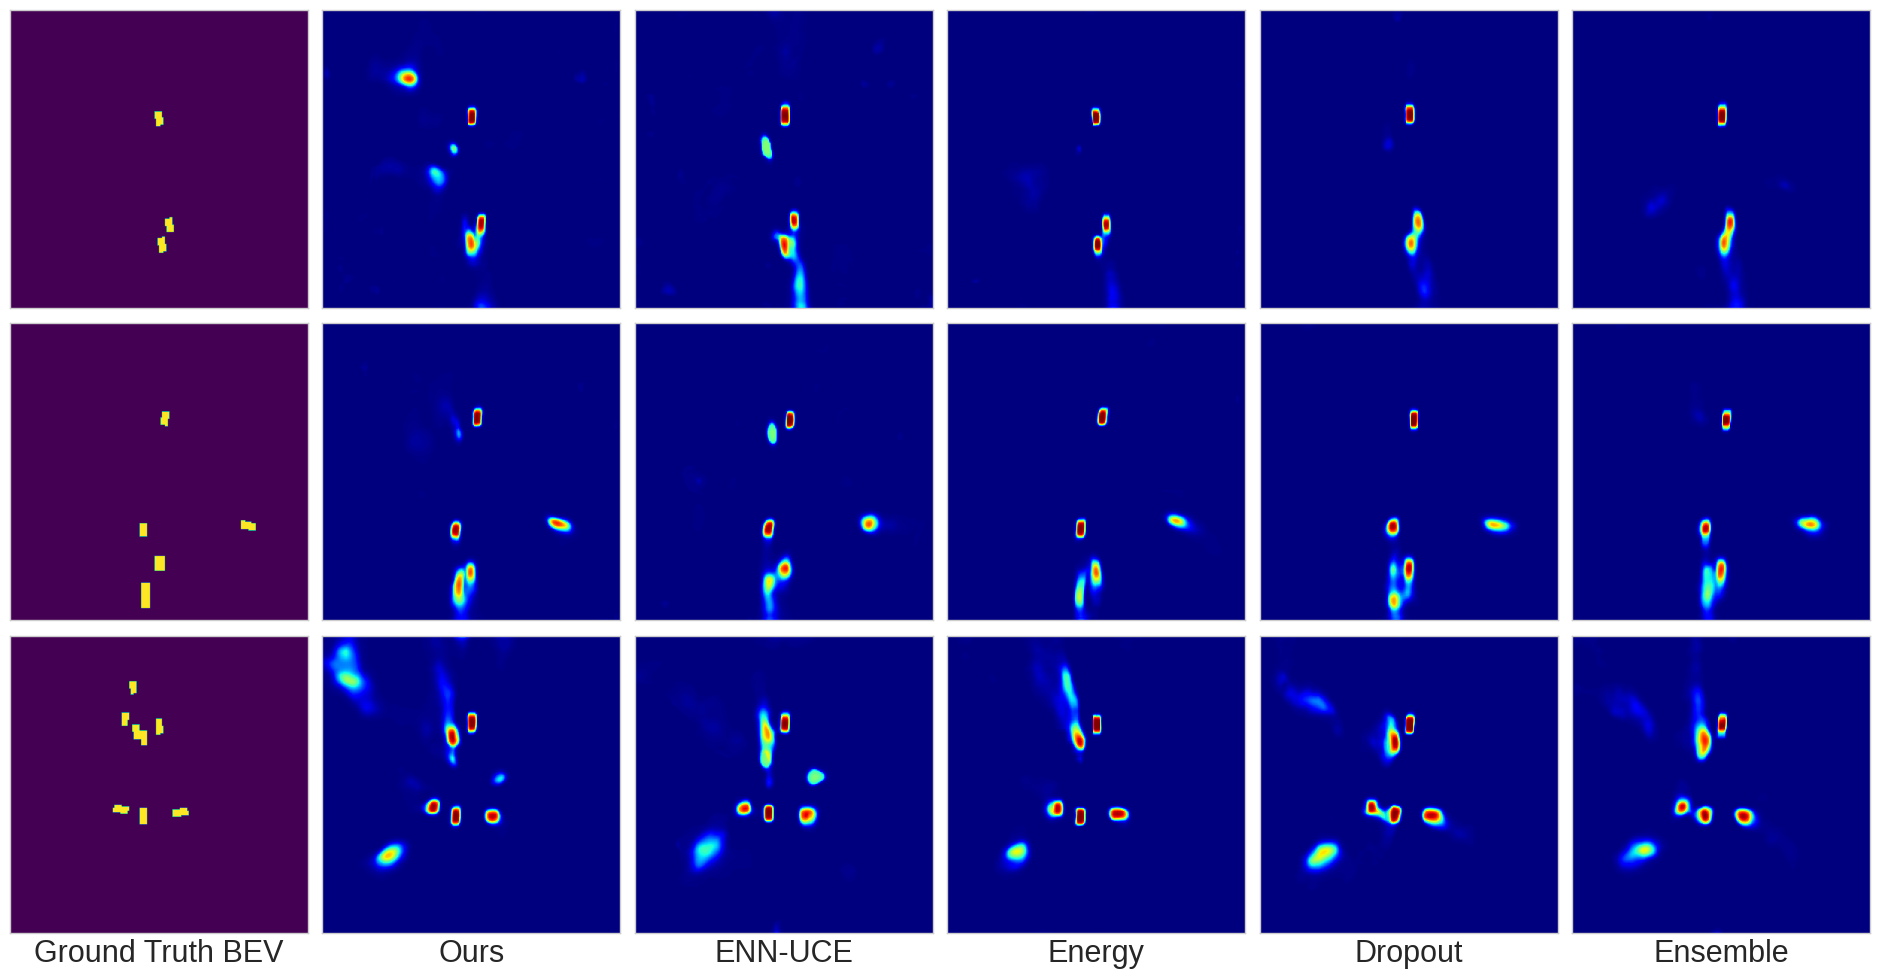

In [18]:
fig, axs = plt.subplots(samples, nmodels+1, figsize=((nmodels + 1) * size, size * (samples)))
fig.subplots_adjust(wspace=.05, hspace=.05)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for i in range(samples):
    images, intrinsics, extrinsics, labels, ood = nusc_data[idxs[i]]
    
    images = images[None].to(7)
    intrinsics = intrinsics[None].to(7)
    extrinsics = extrinsics[None].to(7)
    labels = labels[None].to(7)

    for j, model in enumerate(models):
        logits = model(images, intrinsics, extrinsics).detach().cpu()    
        pred = model.activate(logits)
        axs[i, 0].imshow(labels[0, 0].cpu(), cmap="viridis")
        axs[i, j + 1].imshow(pred[0, 0].cpu(), cmap='jet')

axs[samples-1, 0].set_xlabel("Ground Truth BEV", fontsize=22)

for i, name in enumerate(names):
    axs[samples-1, i+1].set_xlabel(name, fontsize=22)

fig.savefig("class.pdf", format="pdf")


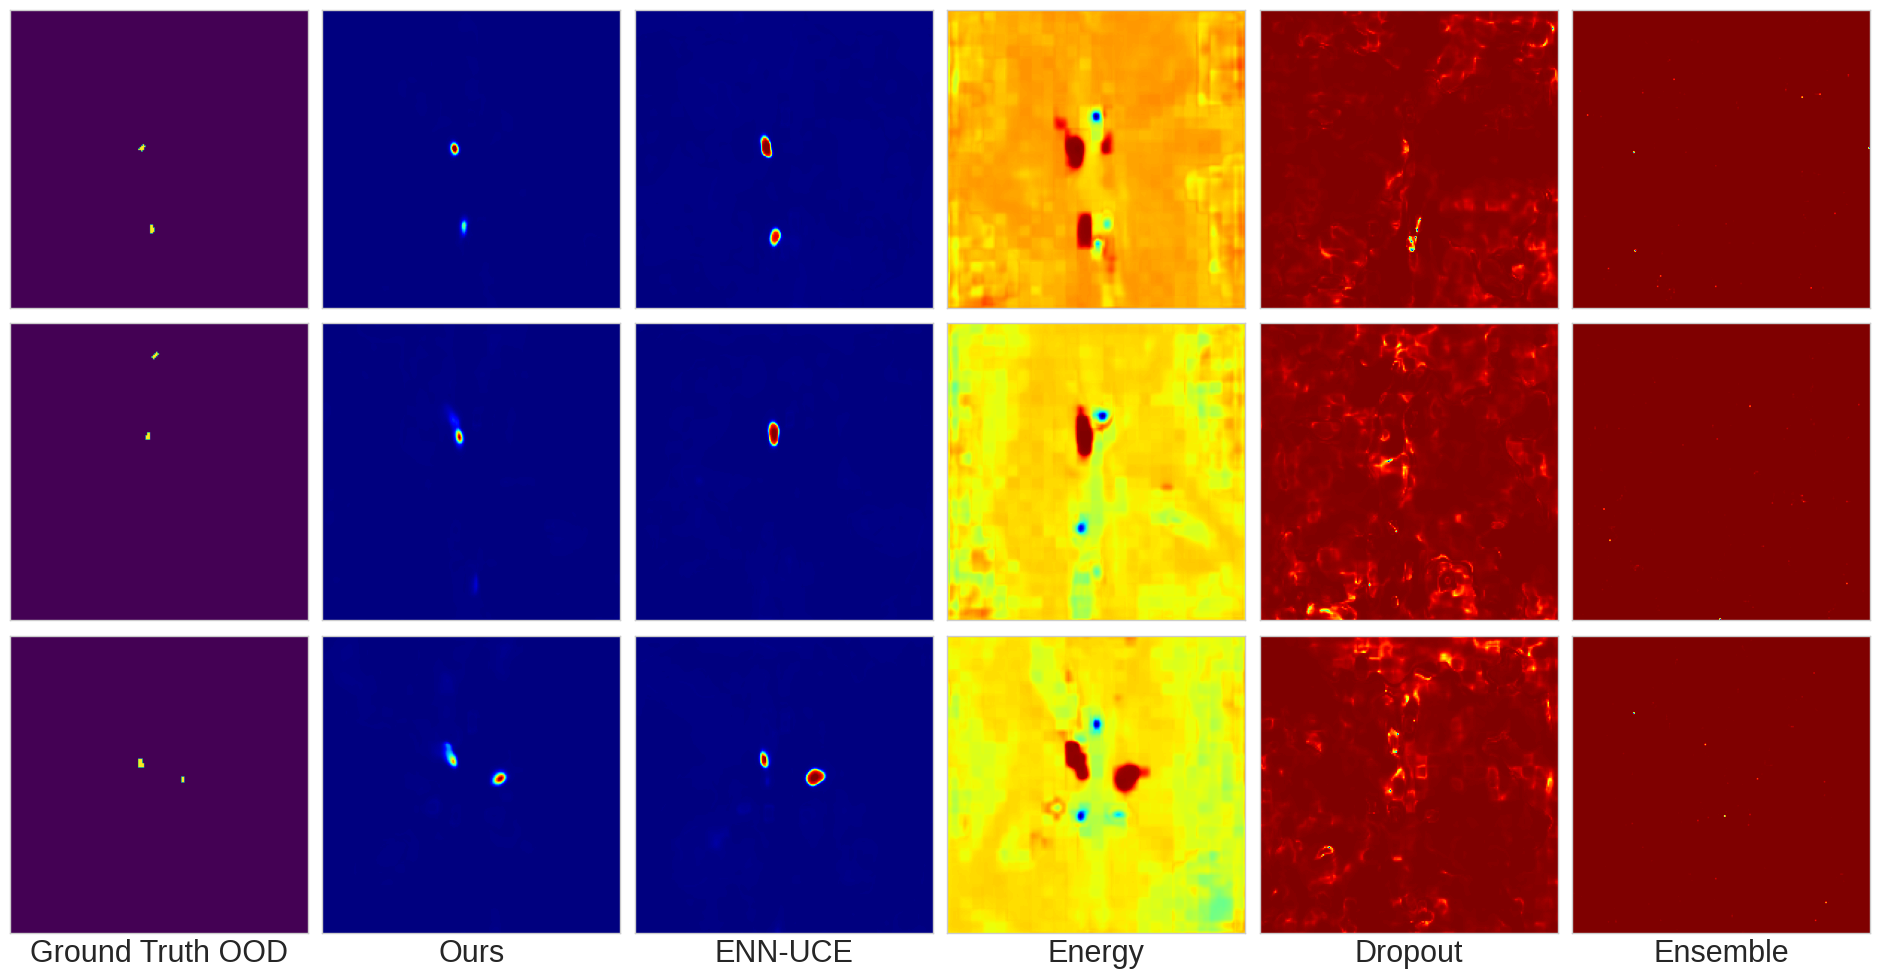

In [20]:
fig, axs = plt.subplots(samples, nmodels+1, figsize=((nmodels + 1) * size, size * (samples)))
fig.subplots_adjust(wspace=.05, hspace=.05)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for i in range(samples):
    images, intrinsics, extrinsics, labels, ood = nusc_data[idxs[i]]
    
    images = images[None].to(7)
    intrinsics = intrinsics[None].to(7)
    extrinsics = extrinsics[None].to(7)
    labels = labels[None].to(7)

    for j, model in enumerate(models):

        logits = model(images, intrinsics, extrinsics).detach().cpu()    
        ep = model.epistemic(logits)    
        axs[i, 0].imshow(ood[0].cpu(), cmap="viridis")
        axs[i, j + 1].imshow(ep[0, 0].cpu(), cmap='jet')
        
axs[samples-1, 0].set_xlabel("Ground Truth OOD", fontsize=22)

for i, name in enumerate(names):
    axs[samples-1, i+1].set_xlabel(name, fontsize=22)

fig.savefig("ood.pdf", format="pdf")


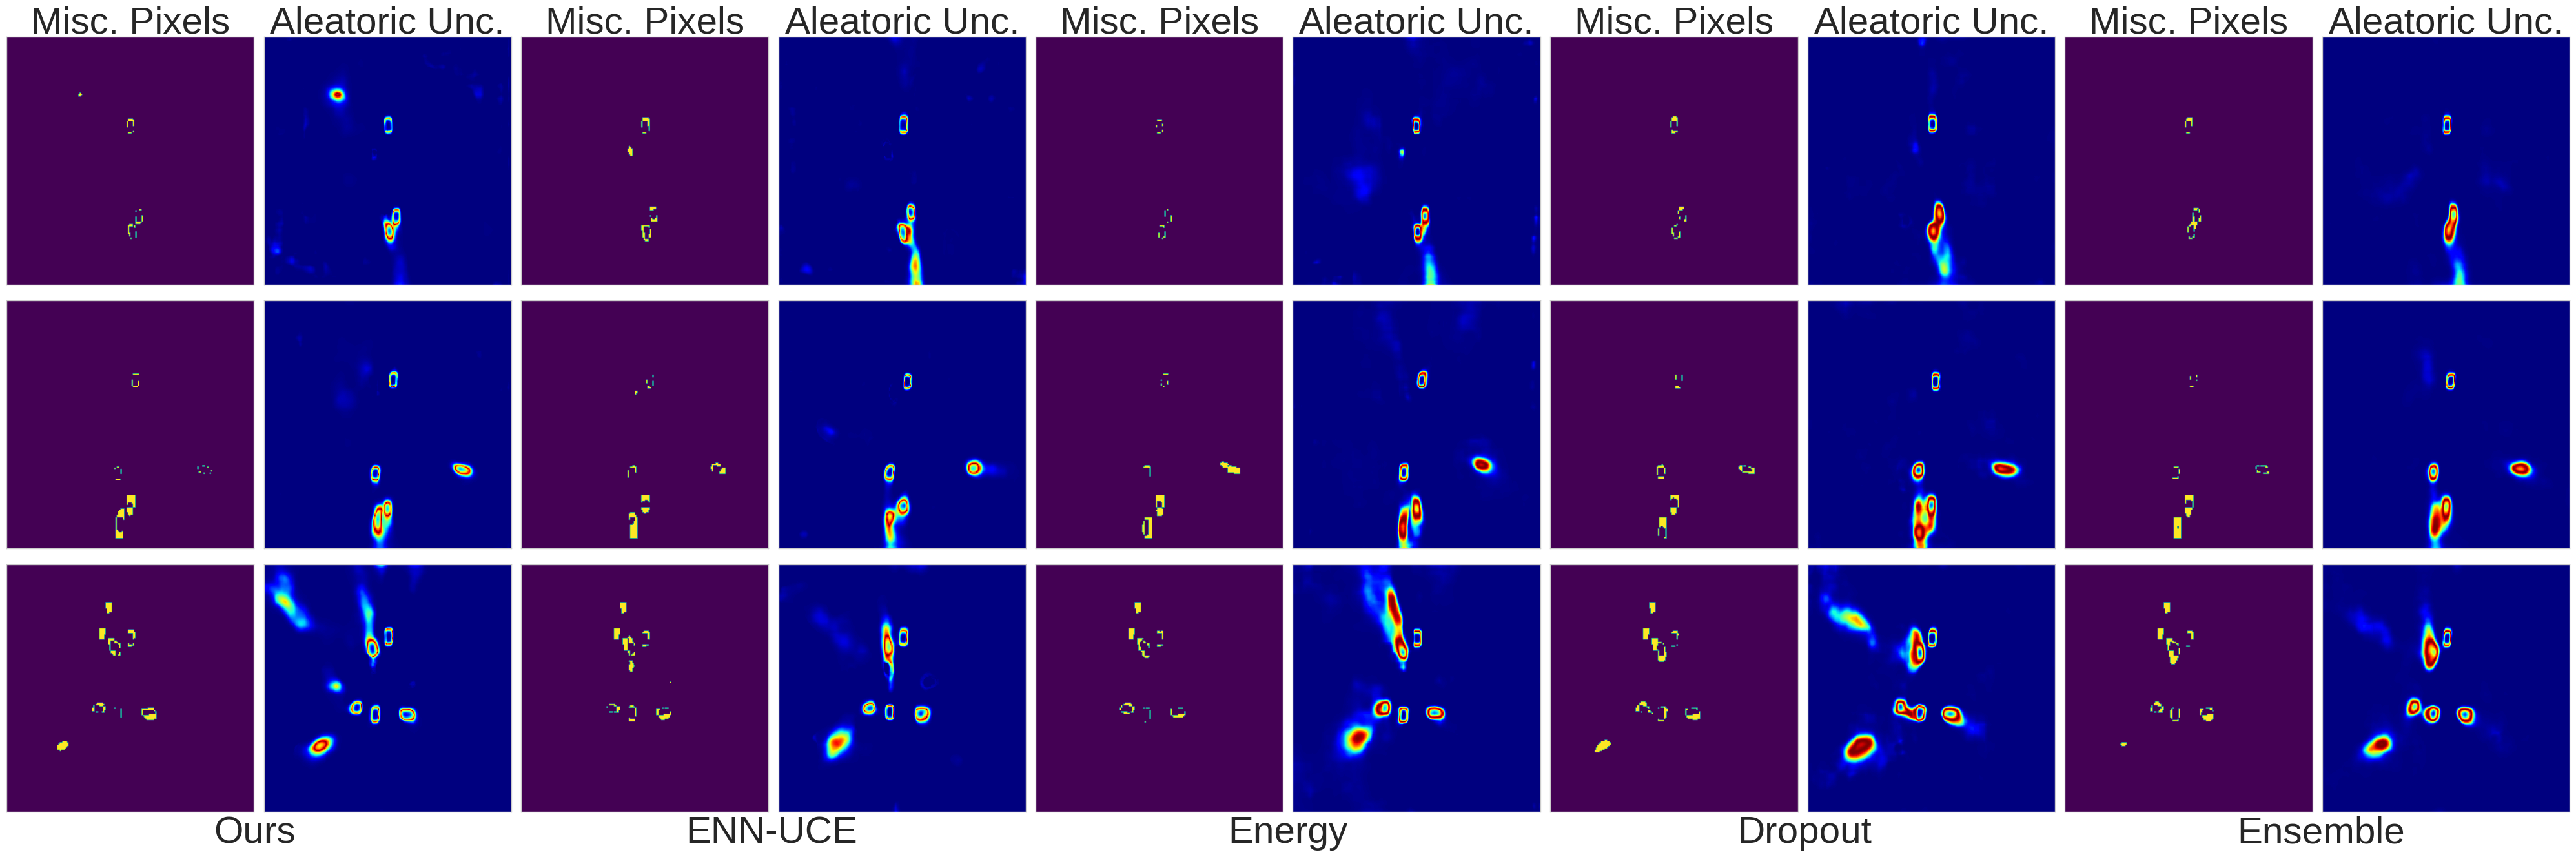

In [25]:
fig, axs = plt.subplots(samples, nmodels*2, figsize=((nmodels*2) * size, size * (samples) + 1))
fig.subplots_adjust(wspace=.05, hspace=.05)
fsz = 42

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for i in range(samples):
    images, intrinsics, extrinsics, labels, ood = nusc_data[idxs[i]]
    
    images = images[None].to(7)
    intrinsics = intrinsics[None].to(7)
    extrinsics = extrinsics[None].to(7)
    labels = labels[None].to(7)

    for j, model in enumerate(models):
        logits = model(images, intrinsics, extrinsics).detach().cpu()    
        pmax = model.activate(logits).argmax(dim=1)
        al = model.aleatoric(logits)    
        lmax = labels.argmax(dim=1)
        m = pmax.cpu() != lmax.cpu()      
        axs[i, j * 2].imshow(m[0].cpu(), cmap="viridis")
        axs[i, j * 2 + 1].imshow(al[0, 0].cpu(), cmap='jet')


for i in range(nmodels):
    axs[0, 2 * i].xaxis.set_label_position('top') 
    axs[0, 2 * i + 1].xaxis.set_label_position('top') 
    axs[0, 2 * i].set_xlabel("Misc. Pixels", fontsize=fsz)
    axs[0, 2 * i + 1].set_xlabel("Aleatoric Unc.", fontsize=fsz)

        
# axs[samples-1, 0].set_xlabel("UFCE VS ER Misclassified Pixels", fontsize=22)
# axs[samples-1, 2].set_xlabel("UCE ENT VS ER", fontsize=22)
# axs[samples-1, 4].set_xlabel("UFCE ER", fontsize=22)
# axs[samples-1, 6].set_xlabel("UFCE", fontsize=22)
# axs[samples-1, 8].set_xlabel("UCE", fontsize=22)
n_labels = len(names)

# Assuming `nmodels` is the number of models you have, and it dictates the column count
# We calculate the midpoints based on subplot positions in the figure
for i, text in enumerate(names):
    # Calculate midpoint position between subplots for the labels
    midpoint = ((2 * i + 1) / (2.0 * nmodels))  # Normalized units from 0 to 1

    # Use figure coordinates to place labels at the bottom, adjusting for tight_layout padding
    fig.text(midpoint, 0, text, ha='center', va='center', fontsize=fsz)


fig.tight_layout()
fig.savefig("mis.pdf", format="pdf", bbox_inches='tight')


In [ ]:
for i in range(100):
    images, intrinsics, extrinsics, labels, ood = nusc_data[i]
    
    images = images[None].to(7)
    intrinsics = intrinsics[None].to(7)
    extrinsics = extrinsics[None].to(7)
    labels = labels[None].to(7)

    logits = ufce_vs_er(images, intrinsics, extrinsics).detach().cpu()    
    ep = model.epistemic(logits)    

    print(i, unc_iou(ep, ood))